Try to understand effects on AC sampling

In [2]:
import numpy as np
from numba import njit
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
from matplotlib.colors import LogNorm, Normalize
import pandas as pd
import pickle
from datetime import datetime,timedelta, date
import strax
import straxen
import cutax
from tqdm.notebook import tqdm, trange
strax.utils.tqdm = tqdm
from multihist import Hist1d, Histdd

import copy
from matplotlib import cm
from scipy import stats
import feldman_cousins as fc
from scipy.stats import poisson
from scipy.optimize import minimize, rosen, rosen_der
import h5py

import GOFevaluation as ge
import scipy.stats as sps
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import json
import cututils

In [3]:
import os
style = os.path.join(os.environ['HOME'], 'nton/mplconfigs/stylelib/xenonnt.mplstyle')   
plt.style.use(style)

In [4]:
%matplotlib inline

In [5]:
mpl.rcParams['figure.dpi'] = 130
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 9

In [6]:
%run -i 'YBe_tool.py'
%run -i 'stuff_to_load.py'
mode='3-fold'
# mode='2-fold-only'

In [7]:
Y88_hl=106.6
kbq_initial=698
kbq_sim=389
day_lapse=-np.log(kbq_sim/kbq_initial)/np.log(2)*Y88_hl
#2022-6-1 initial date
source_date=datetime(2022,6,1)+timedelta(days=day_lapse)
dt=(datetime(2022,10,5)-source_date)/timedelta(days=1)

In [8]:
hour=183.78

# gamma_ineff=0.9 #NR inefficincy due to gamma coincident
# start_to_mid=0.9809

gamma_ratio=0.93356 #gamma ratio between YBe and Y88 run
# one_week_decay=np.exp(-7/(Y88_hl/np.log(2))) #fitted source decay rate

# sim_ratio=1/(start_to_mid*one_week_decay**2) #old scaling
sim_ratio=1/(np.exp(-dt/(Y88_hl/np.log(2)))) #new scaling

s_hour=15393*sim_ratio #hours of simulation, in the same rate as YBe run
b_hour=142.21*gamma_ratio #hours of background run, in the rate, in the same rate as YBe run
y_hour=365*24
bkg_s=hour/b_hour #pre-scaling for Y88 
sim_s=hour/s_hour #pre-scaling for YBe simulation

In [9]:
# data_cuts=pd.read_hdf("good_data.hdf5")
bkg=pd.read_hdf("/project2/lgrandi/dali/sghosh/Y88_event_info_143runs_142.21hrs_all_cuts_with_run_ids_v2.hdf5")
data=pd.read_hdf("/project2/lgrandi/dali/sghosh/YBe_event_info_239runs_183.78hrs_all_cuts_with_run_ids_v2.hdf5")


# bkg=pd.read_hdf("/dali/lgrandi/ghusheng/YBe_data/YBe_superrun/Y88_event_info_143runs_142.21hrs_all_cuts_with_run_ids.hdf5")
# data=pd.read_hdf("/dali/lgrandi/ghusheng/YBe_data/YBe_superrun/YBe_event_info_239runs_183.78hrs_all_cuts_with_run_ids.hdf5")
# # sim=pd.read_hdf("good_sim.hdf5") #3-fold
# sim_raw=pd.read_csv("/dali/lgrandi/pkavrigin/2022-10-19_YBeNeutron/event_info.csv") #raw sim
sim_raw=pd.read_csv("/project2/lgrandi/ghusheng/YBe_sim/ybeneu_low_event_info.csv")



In [10]:

    
def df_2fold(df,no_3fold=True):
    return df[df.s1_tight_coincidence>=2]
    # if no_3fold==True:
    #     return df[(df['cut_s1_tightcoin_3fold']==False)&(df.s1_n_hits==2)]
    # else:
    #     return df[(df.s1_n_hits==2)]
def df_cut_SA(data_cuts_2only):
    return data_cuts_2only[(data_cuts_2only.cut_position_shadow)&(data_cuts_2only.cut_time_shadow)&(data_cuts_2only.cut_ambience)]

In [11]:
def fv_cut(df):
    return df[df.cut_fiducial_volume]

In [12]:
#quality cuts 3fold
if mode=='3-fold':
    ac_h5 = '/project2/lgrandi/ghusheng/YBe_sim/ac_ybe_0109.h5'

    with h5py.File(ac_h5, 'r', libver='latest', swmr=True) as ipt:
        normalization = ipt['fold3_df'].attrs['normalization']

    ac_sim = pd.read_hdf(ac_h5, key='fold3_df')#, columns=['cs1', 'cs2', 'cut_fiducial_volume', 'cut_near_wires','x','y','r','z'])
    data_cuts = data.query(' and '.join(targets_minimal[1:]))
    bkg_cuts = bkg.query(' and '.join(targets_minimal[1:]))
    sim = sim_raw.query(' and '.join(targets_minimal[1:]))
    ac_sim_cuts = ac_sim[ac_sim.cut_fiducial_volume]
    s1_bins=np.linspace(2.5,20.5,19)
    # del bkg
    # del data
    # del sim_raw

In [13]:

bkg_sim_s=hour/y_hour* normalization
bkg_sim_s

7.831916937676494e-05

In [14]:
data_clean=wire_cut(df_cut_SA(data_cuts))
sim_clean=wire_cut(sim)
bkg_clean=wire_cut(df_cut_SA(bkg_cuts))
ac_sim_cuts['s2_x']=ac_sim_cuts['x']
ac_sim_cuts['s2_y']=ac_sim_cuts['y']
ac_sim_clean=wire_cut(ac_sim_cuts)

/tmp/jobs/27004138/ipykernel_3431/2534468804.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ac_sim_cuts['s2_x']=ac_sim_cuts['x']
/tmp/jobs/27004138/ipykernel_3431/2534468804.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ac_sim_cuts['s2_y']=ac_sim_cuts['y']


In [15]:
data_clean=cut_cs1cs2(data_clean,cs1=[0,10],cs2=[100,200])
sim_clean=cut_cs1cs2(sim_clean,cs1=[0,10],cs2=[100,200])
ac_sim_clean=cut_cs1cs2(ac_sim_clean,cs1=[0,10],cs2=[100,200])
bkg_clean=cut_cs1cs2(bkg_clean,cs1=[0,10],cs2=[100,200])

In [16]:
ac_sim_clean.loc[:,'ac']=np.ones(len(ac_sim_clean),dtype=int)
sim_clean.loc[:,'ac']=np.zeros(len(sim_clean),dtype=int)

In [17]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
from sklearn import preprocessing
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
# from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB# try other model 
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
sns.set_style("darkgrid")
from sklearn.inspection import permutation_importance
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)



2023-04-17 15:33:29.026713: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/XENONnT/anaconda/envs/XENONnT_2022.09.1/lib64:/opt/XENONnT/anaconda/envs/XENONnT_2022.09.1/lib:/opt/rh/devtoolset-9/root/usr/lib64:/opt/rh/devtoolset-9/root/usr/lib:/opt/rh/devtoolset-9/root/usr/lib64/dyninst:/opt/rh/devtoolset-9/root/usr/lib/dyninst:/opt/rh/devtoolset-9/root/usr/lib64:/opt/rh/devtoolset-9/root/usr/lib
2023-04-17 15:33:29.026768: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [18]:
# Get a list of unique [['drift_time', 's2_range_50p_area', 's2_area']] values
unique_values = ac_sim_clean[['s2_range_50p_area', 's2_area']].drop_duplicates()

# Split the unique values into two sets with an 8:2 ratio
a, b = train_test_split(unique_values, test_size=0.2, random_state=42)

# Get the rows in ac_sim_clean that have [['drift_time', 's2_range_50p_area', 's2_area']] in set a or b
ac_train = ac_sim_clean[ac_sim_clean[['s2_range_50p_area', 's2_area']].apply(lambda row: tuple(row) in a.values, axis=1)]
ac_test = ac_sim_clean[ac_sim_clean[['s2_range_50p_area', 's2_area']].apply(lambda row: tuple(row) in b.values, axis=1)]


In [19]:
sim_train, sim_test = train_test_split(sim_clean, test_size=0.2, random_state=42)
ac_train=get_random(ac_train,len(sim_train))
ac_test=get_random(ac_test,len(sim_test))

[0]	validation_0-auc:0.89567	validation_1-auc:0.86649
[1]	validation_0-auc:0.91643	validation_1-auc:0.89451


/home/scli/.local/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[2]	validation_0-auc:0.92691	validation_1-auc:0.90301
[3]	validation_0-auc:0.93198	validation_1-auc:0.90740
[4]	validation_0-auc:0.93560	validation_1-auc:0.90999
[5]	validation_0-auc:0.93746	validation_1-auc:0.91161
[6]	validation_0-auc:0.93989	validation_1-auc:0.91337
[7]	validation_0-auc:0.94227	validation_1-auc:0.91423
[8]	validation_0-auc:0.94401	validation_1-auc:0.91545
[9]	validation_0-auc:0.94502	validation_1-auc:0.91635
[10]	validation_0-auc:0.94608	validation_1-auc:0.91733
[11]	validation_0-auc:0.94662	validation_1-auc:0.91790
[12]	validation_0-auc:0.95096	validation_1-auc:0.91905
[13]	validation_0-auc:0.95136	validation_1-auc:0.91966
[14]	validation_0-auc:0.95158	validation_1-auc:0.91945
[15]	validation_0-auc:0.95188	validation_1-auc:0.91954
[16]	validation_0-auc:0.95243	validation_1-auc:0.91926
[17]	validation_0-auc:0.95304	validation_1-auc:0.91954
[18]	validation_0-auc:0.95324	validation_1-auc:0.91973
[19]	validation_0-auc:0.95519	validation_1-auc:0.91979
[20]	validation_0-

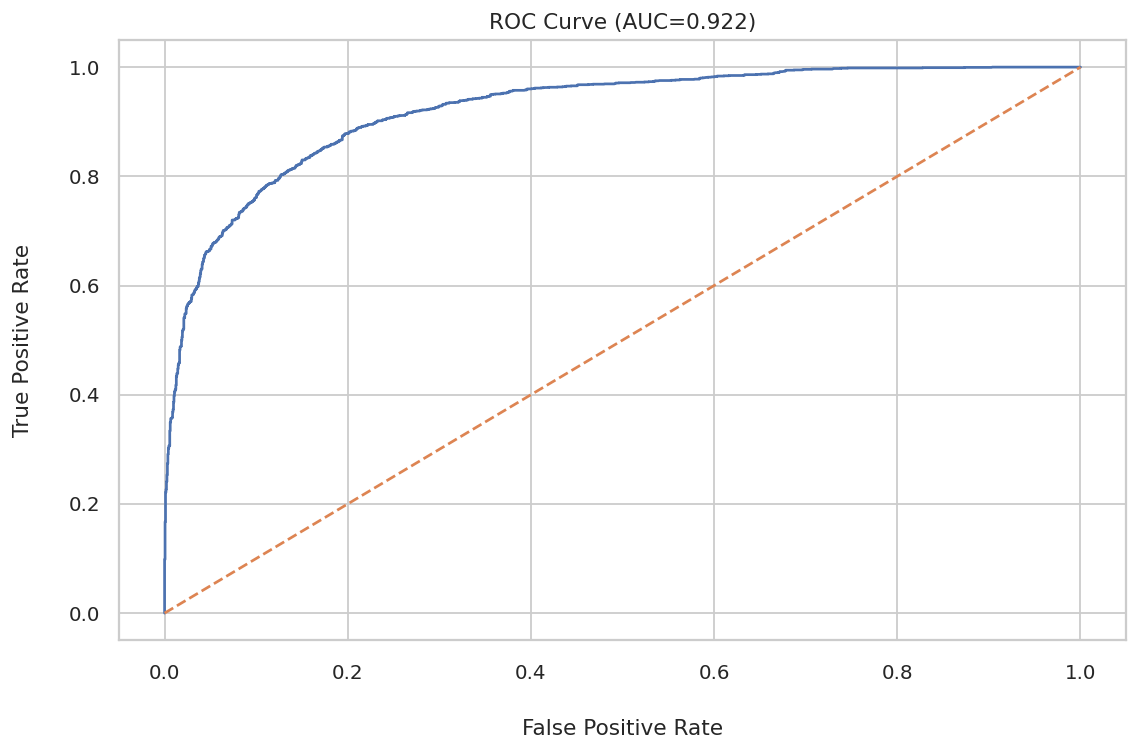

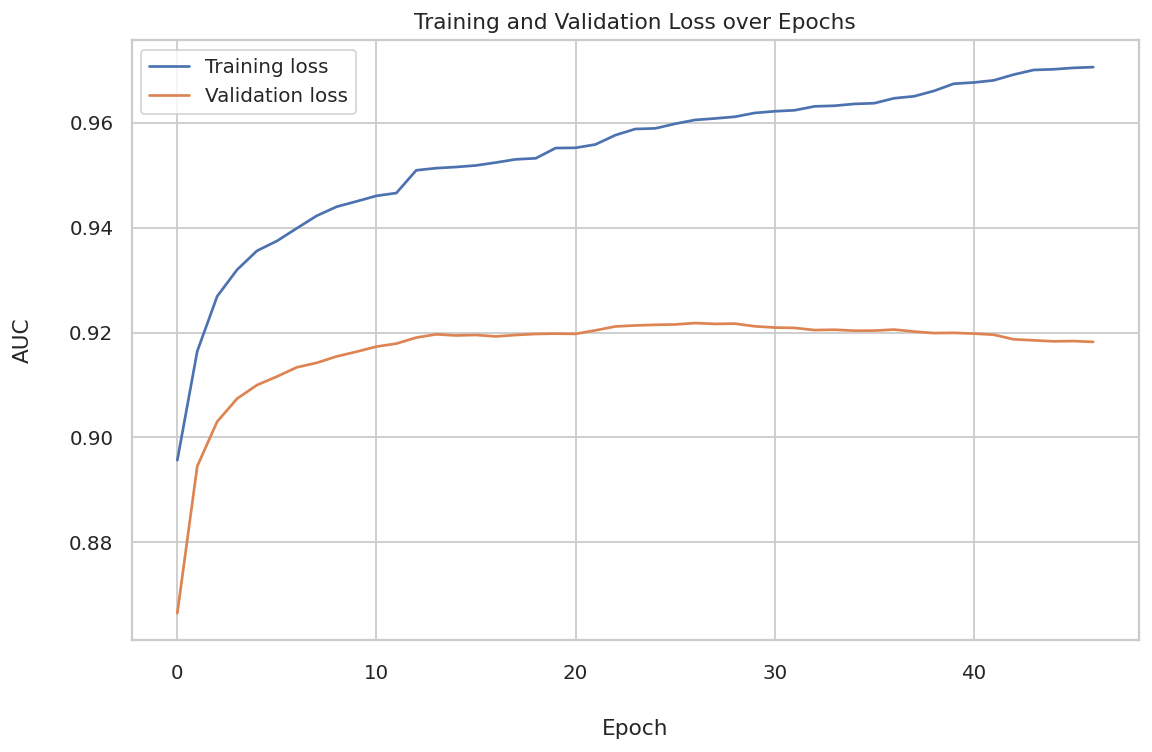

In [20]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


# Combine sim_train and ac_train to create the training set
train = pd.concat([sim_train, ac_train], axis=0).sample(frac=1).reset_index(drop=True)

# Combine sim_test and ac_test to create the test set
test = pd.concat([sim_test, ac_test], axis=0).sample(frac=1).reset_index(drop=True)

# Select the desired features for both sets
features = ['drift_time', 's2_range_50p_area',  'ac','s2_x','s2_y']
train = train[features]
test = test[features]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train[['drift_time', 's2_range_50p_area', 's2_x','s2_y']], test[['drift_time', 's2_range_50p_area','s2_x','s2_y']], train['ac'], test['ac']

# Create an XGBoost model
model = xgb.XGBClassifier(objective='binary:logistic', random_state=42, early_stopping_rounds=20,)

# Train the model using early stopping
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train,  eval_metric="auc", eval_set=eval_set)

# Evaluate the model using ROC curve
y_pred_proba = model.predict_proba(X_test)[:,1]
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Plot the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (AUC={roc_auc:.3f})')
plt.show()

# Plot the training and validation loss over epochs
results = model.evals_result()
train_loss = results['validation_0']['auc']
val_loss = results['validation_1']['auc']
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()


In [21]:
from sklearn.metrics import accuracy_score
y_pred = model.predict(X_test)
accuracy_score(y_test,y_pred)

0.8348694316436251

In [22]:
# from sklearn.metrics import accuracy_score
# y_pred_ac = model.predict(X_test_ac)
# accuracy_score(y_test_ac,y_pred_ac)

In [23]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # Choose two of the three common features for all dataframes
# feature_pairs = [('drift_time', 's2_range_50p_area'), ('s2_range_50p_area', 's2_area'), ('drift_time', 's2_area'),('s2_x', 's2_y')]
# features = ['drift_time', 's2_range_50p_area', 's2_area','s2_x','s2_y']

# # Make predictions on the test set using the XGBoost model
# ac_sim_clean_pred = model.predict_proba(ac_sim_clean[features])[:,1]
# sim_clean_pred = model.predict_proba(sim_clean[features])[:,1]
# data_clean_pred = model.predict_proba(data_clean[features])[:,1]
# bkg_clean_pred = model.predict_proba(bkg_clean[features])[:,1]
# # ac_sim_clean_pred_old = model.predict_proba(ac_sim_clean_old[features])[:,1]
# ac_sim_clean['ac_score'] = ac_sim_clean_pred
# sim_clean['ac_score'] = sim_clean_pred
# data_clean['ac_score'] = data_clean_pred
# bkg_clean['ac_score'] = bkg_clean_pred
# # ac_sim_clean_old['ac_score'] = ac_sim_clean_pred_old


# # Plot the scatter plots with color bar
# fig, axs = plt.subplots(4, 4, figsize=(30,15), sharey=False)
# for i, (f1, f2) in enumerate(feature_pairs):
#     for j, (df, df_pred, name) in enumerate(zip([ac_sim_clean, sim_clean, data_clean, bkg_clean], [ac_sim_clean_pred, sim_clean_pred, data_clean_pred, bkg_clean_pred], ['AC', 'YBe Simulation', 'YBe Data', 'Y88 Data'])):
#         size=2
#         if name=='YBe Data' or name=='Y88 Data':
#             size=40
#         if f2 == 's2_area':
#             axs[i, j].scatter(df[f1], df[f2], c=df_pred, cmap='coolwarm', s=size, alpha=0.9, vmin=0, vmax=1)
#             axs[i, j].set_xlabel(f1)
#             axs[i, j].set_ylabel(f2)
#             axs[i, j].set_title(f'{name}')
#             axs[i, j].set_yscale('log')
#             axs[i, j].set_ylim(90,1100)
#             fig.colorbar(axs[i, j].collections[0], ax=axs[i, j], fraction=0.046, pad=0.04)
#         else:
#             axs[i, j].scatter(df[f1], df[f2], c=df_pred, cmap='coolwarm', s=size, alpha=0.9, vmin=0, vmax=1)
#             axs[i, j].set_xlabel(f1)
#             axs[i, j].set_ylabel(f2)
#             axs[i, j].set_title(f'{name}')
#             fig.colorbar(axs[i, j].collections[0], ax=axs[i, j], fraction=0.046, pad=0.04)

# plt.tight_layout()
# plt.show()


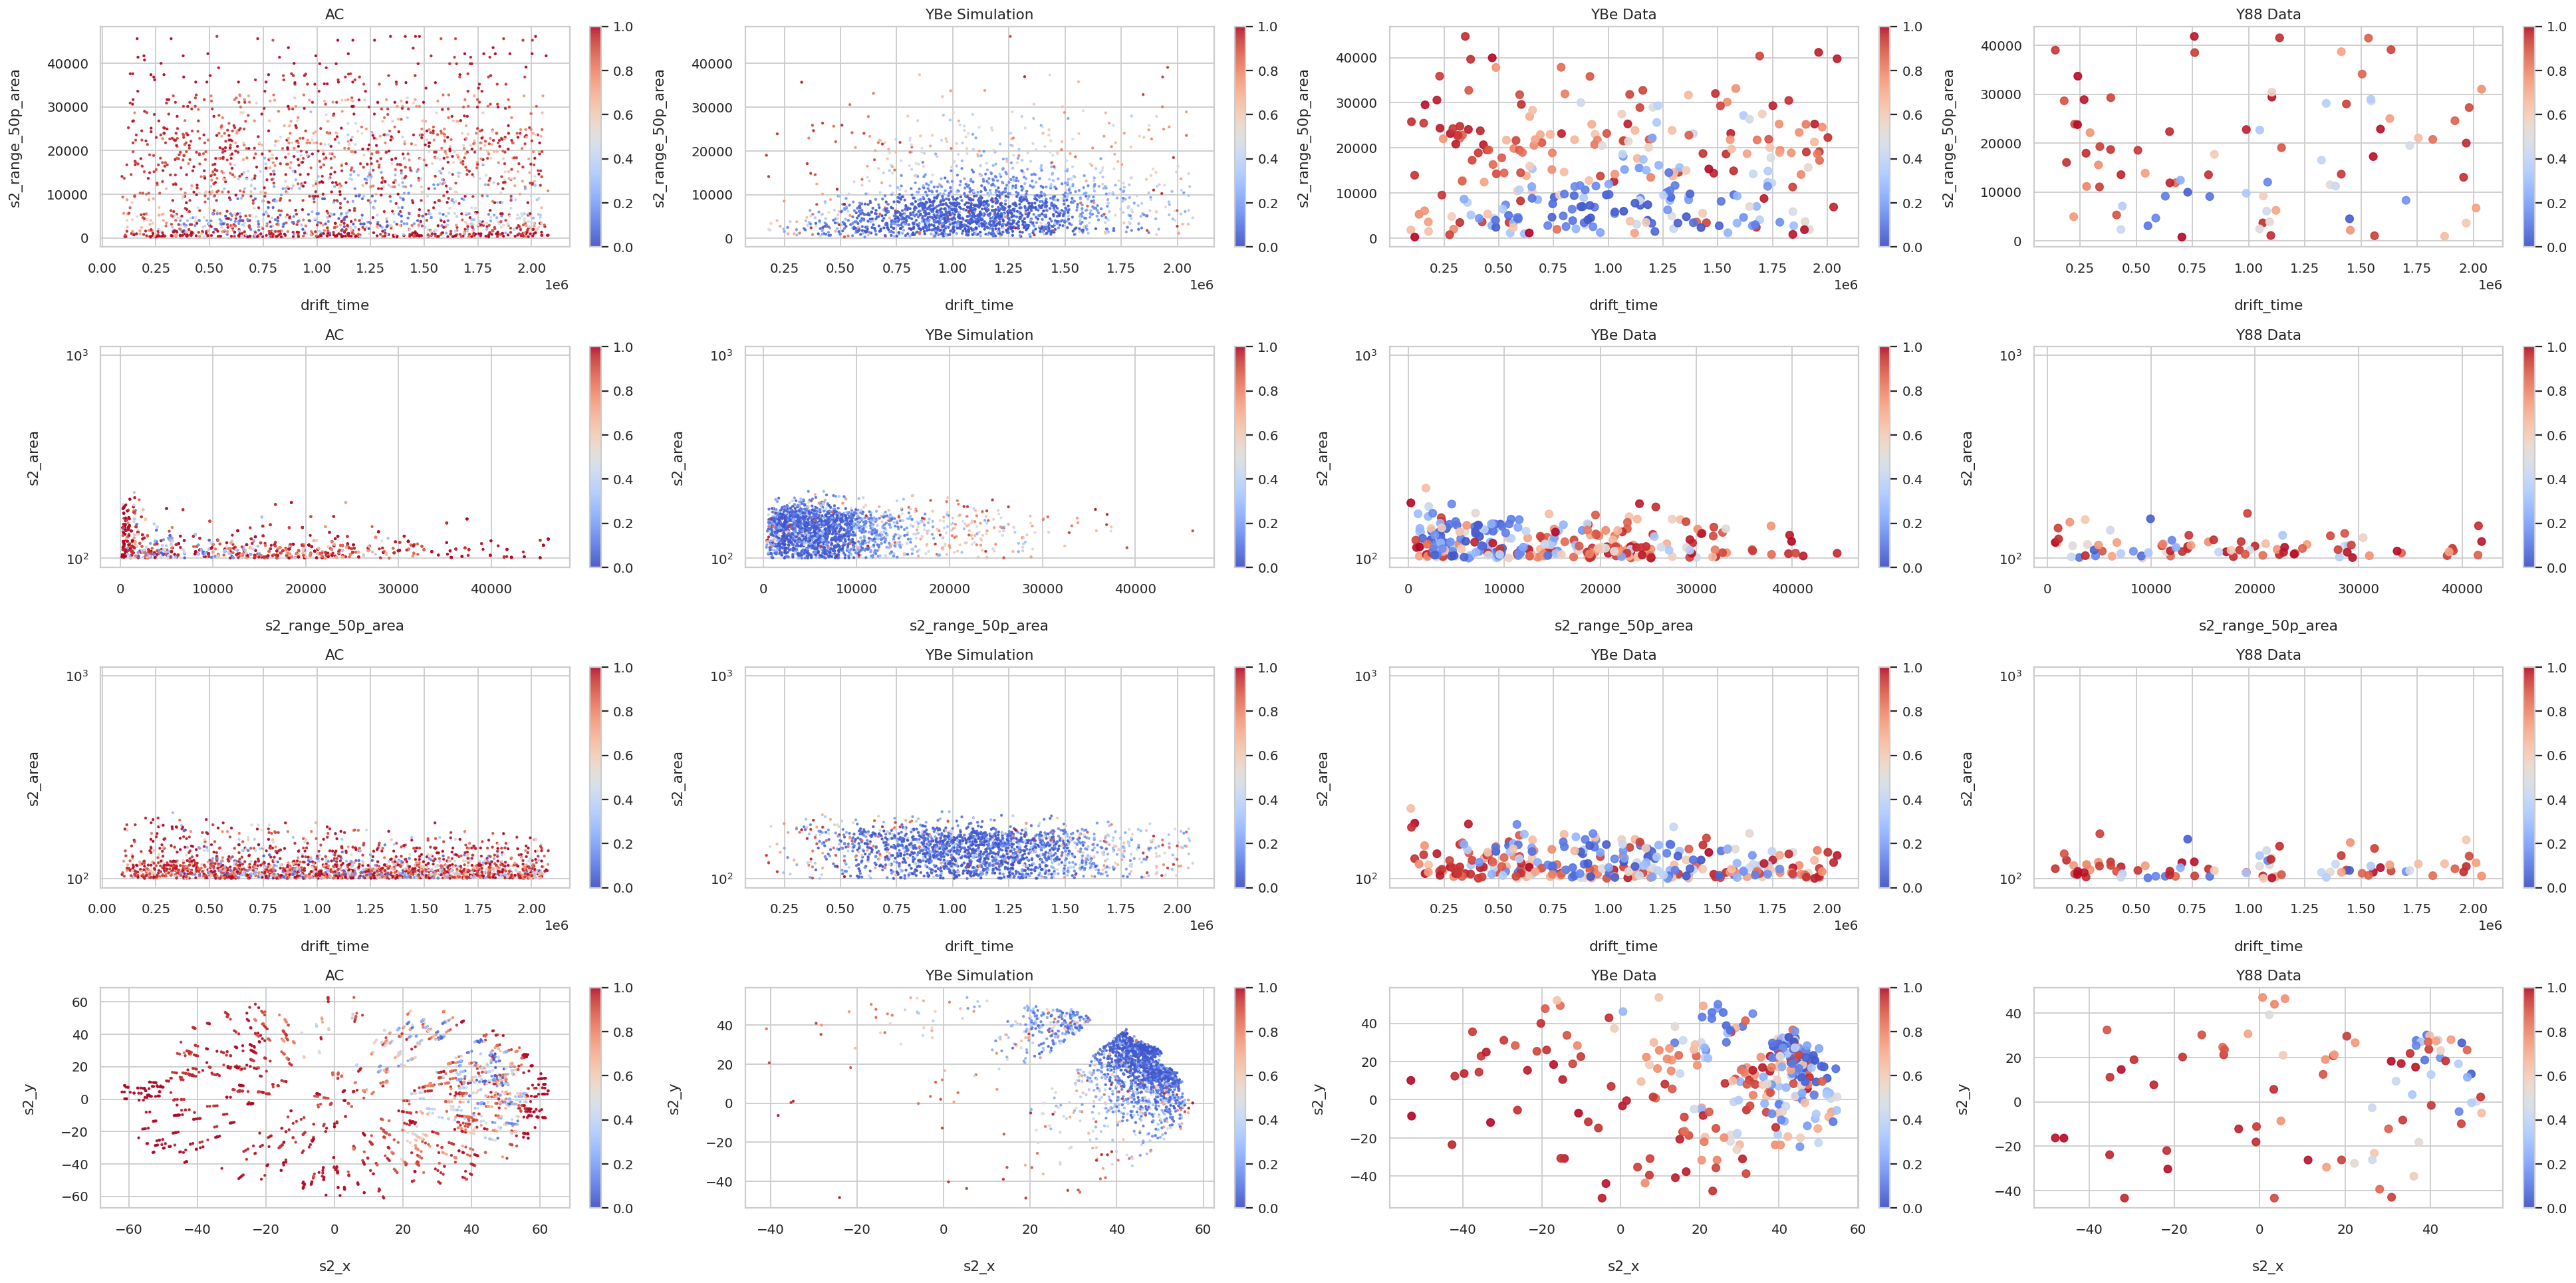

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Choose two of the three common features for all dataframes
feature_pairs = [('drift_time', 's2_range_50p_area'), ('s2_range_50p_area', 's2_area'), ('drift_time', 's2_area'),('s2_x', 's2_y')]
features = ['drift_time', 's2_range_50p_area', 's2_x','s2_y']

# Make predictions on the test set using the XGBoost model
ac_test_pred = model.predict_proba(ac_test[features])[:,1]
sim_test_pred = model.predict_proba(sim_test[features])[:,1]
data_clean_pred = model.predict_proba(data_clean[features])[:,1]
bkg_clean_pred = model.predict_proba(bkg_clean[features])[:,1]
ac_test['ac_score'] = ac_test_pred
sim_test['ac_score'] = sim_test_pred
data_clean['ac_score'] = data_clean_pred
bkg_clean['ac_score'] = bkg_clean_pred



# Plot the scatter plots with color bar
fig, axs = plt.subplots(4, 4, figsize=(30,15), sharey=False)
for i, (f1, f2) in enumerate(feature_pairs):
    for j, (df, df_pred, name) in enumerate(zip([ac_test, sim_test, data_clean, bkg_clean], [ac_test_pred, sim_test_pred, data_clean_pred, bkg_clean_pred], ['AC', 'YBe Simulation', 'YBe Data', 'Y88 Data'])):
        size=2
        if name=='YBe Data' or name=='Y88 Data':
            size=40
        if f2 == 's2_area':
            axs[i, j].scatter(df[f1], df[f2], c=df_pred, cmap='coolwarm', s=size, alpha=0.9, vmin=0, vmax=1)
            axs[i, j].set_xlabel(f1)
            axs[i, j].set_ylabel(f2)
            axs[i, j].set_title(f'{name}')
            axs[i, j].set_yscale('log')
            axs[i, j].set_ylim(90,1100)
            fig.colorbar(axs[i, j].collections[0], ax=axs[i, j], fraction=0.046, pad=0.04)
        else:
            axs[i, j].scatter(df[f1], df[f2], c=df_pred, cmap='coolwarm', s=size, alpha=0.9, vmin=0, vmax=1)
            axs[i, j].set_xlabel(f1)
            axs[i, j].set_ylabel(f2)
            axs[i, j].set_title(f'{name}')
            fig.colorbar(axs[i, j].collections[0], ax=axs[i, j], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


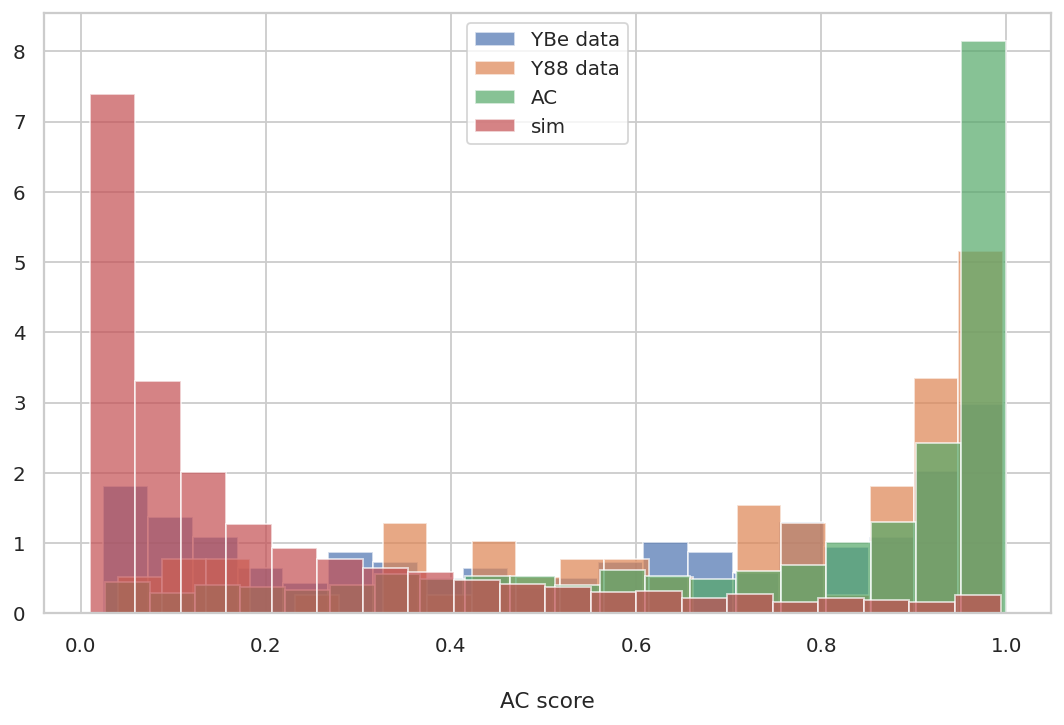

In [25]:
plt.hist(data_clean_pred,bins=20,density=True,label='YBe data',alpha=0.7)
plt.hist(bkg_clean_pred,bins=20,density=True,label='Y88 data',alpha=0.7)
plt.hist(ac_test_pred,bins=20,density=True,label='AC',alpha=0.7)
plt.hist(sim_test_pred,bins=20,density=True,label='sim',alpha=0.7)
plt.xlabel('AC score')
plt.legend()
plt.show()

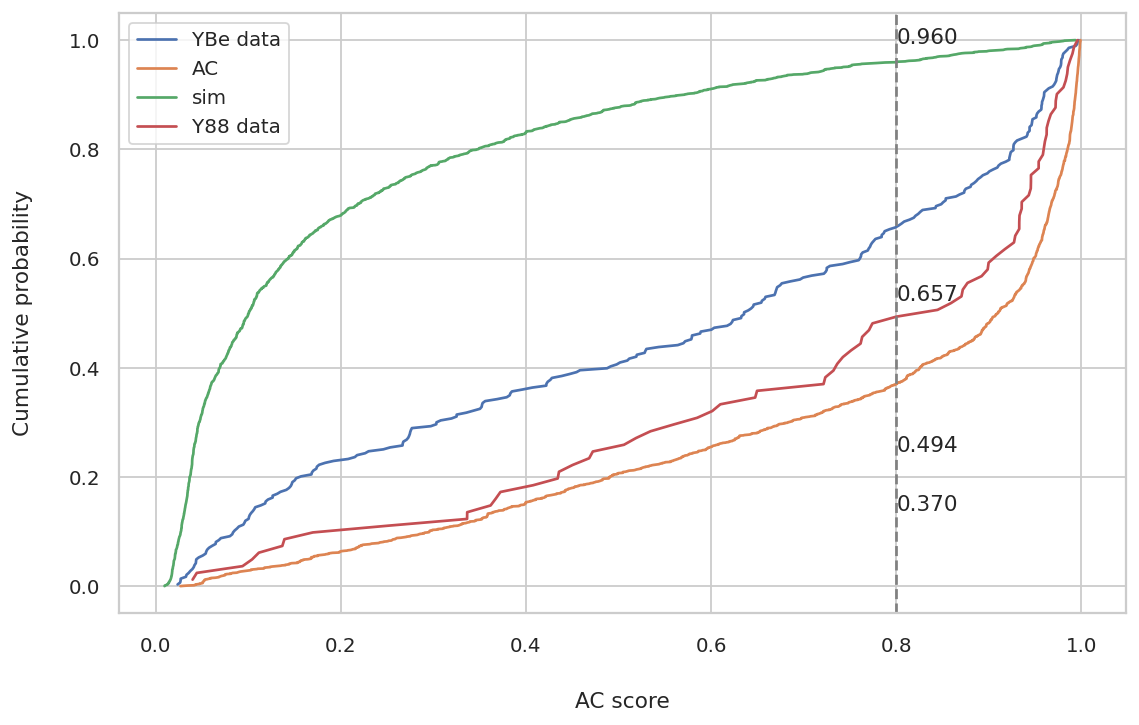

In [26]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

ac_thred=0.8

# Compute the ECDF of the AC scores for each dataframe
ecdf_data_clean = sm.distributions.ECDF(data_clean_pred)
ecdf_ac_sim_clean = sm.distributions.ECDF(ac_test_pred)
ecdf_sim_clean = sm.distributions.ECDF(sim_test_pred)
ecdf_bkg_clean = sm.distributions.ECDF(bkg_clean_pred)

# Plot the CDFs
plt.plot(ecdf_data_clean.x, ecdf_data_clean.y, label='YBe data')
plt.plot(ecdf_ac_sim_clean.x, ecdf_ac_sim_clean.y, label='AC')
plt.plot(ecdf_sim_clean.x, ecdf_sim_clean.y, label='sim')
plt.plot(ecdf_bkg_clean.x, ecdf_bkg_clean.y, label='Y88 data')
plt.axvline(ac_thred, color='grey', linestyle='--')
plt.xlabel('AC score')
plt.ylabel('Cumulative probability')
plt.legend()

# Calculate intersection values
ac_threshold = ecdf_ac_sim_clean.y[np.argmin(np.abs(ecdf_ac_sim_clean.x - ac_thred))]
data_threshold = ecdf_data_clean.y[np.argmin(np.abs(ecdf_data_clean.x - ac_thred))]
sim_threshold = ecdf_sim_clean.y[np.argmin(np.abs(ecdf_sim_clean.x - ac_thred))]
bkg_threshold = ecdf_bkg_clean.y[np.argmin(np.abs(ecdf_bkg_clean.x - ac_thred))]

# Show intersection values
plt.text(ac_thred, ecdf_ac_sim_clean(ac_threshold), f'{ac_threshold:.3f}', fontsize=12)
plt.text(ac_thred, ecdf_data_clean(data_threshold), f'{data_threshold:.3f}', fontsize=12)
plt.text(ac_thred, ecdf_sim_clean(sim_threshold), f'{sim_threshold:.3f}', fontsize=12)
plt.text(ac_thred, ecdf_bkg_clean(bkg_threshold), f'{bkg_threshold:.3f}', fontsize=12)

plt.show()


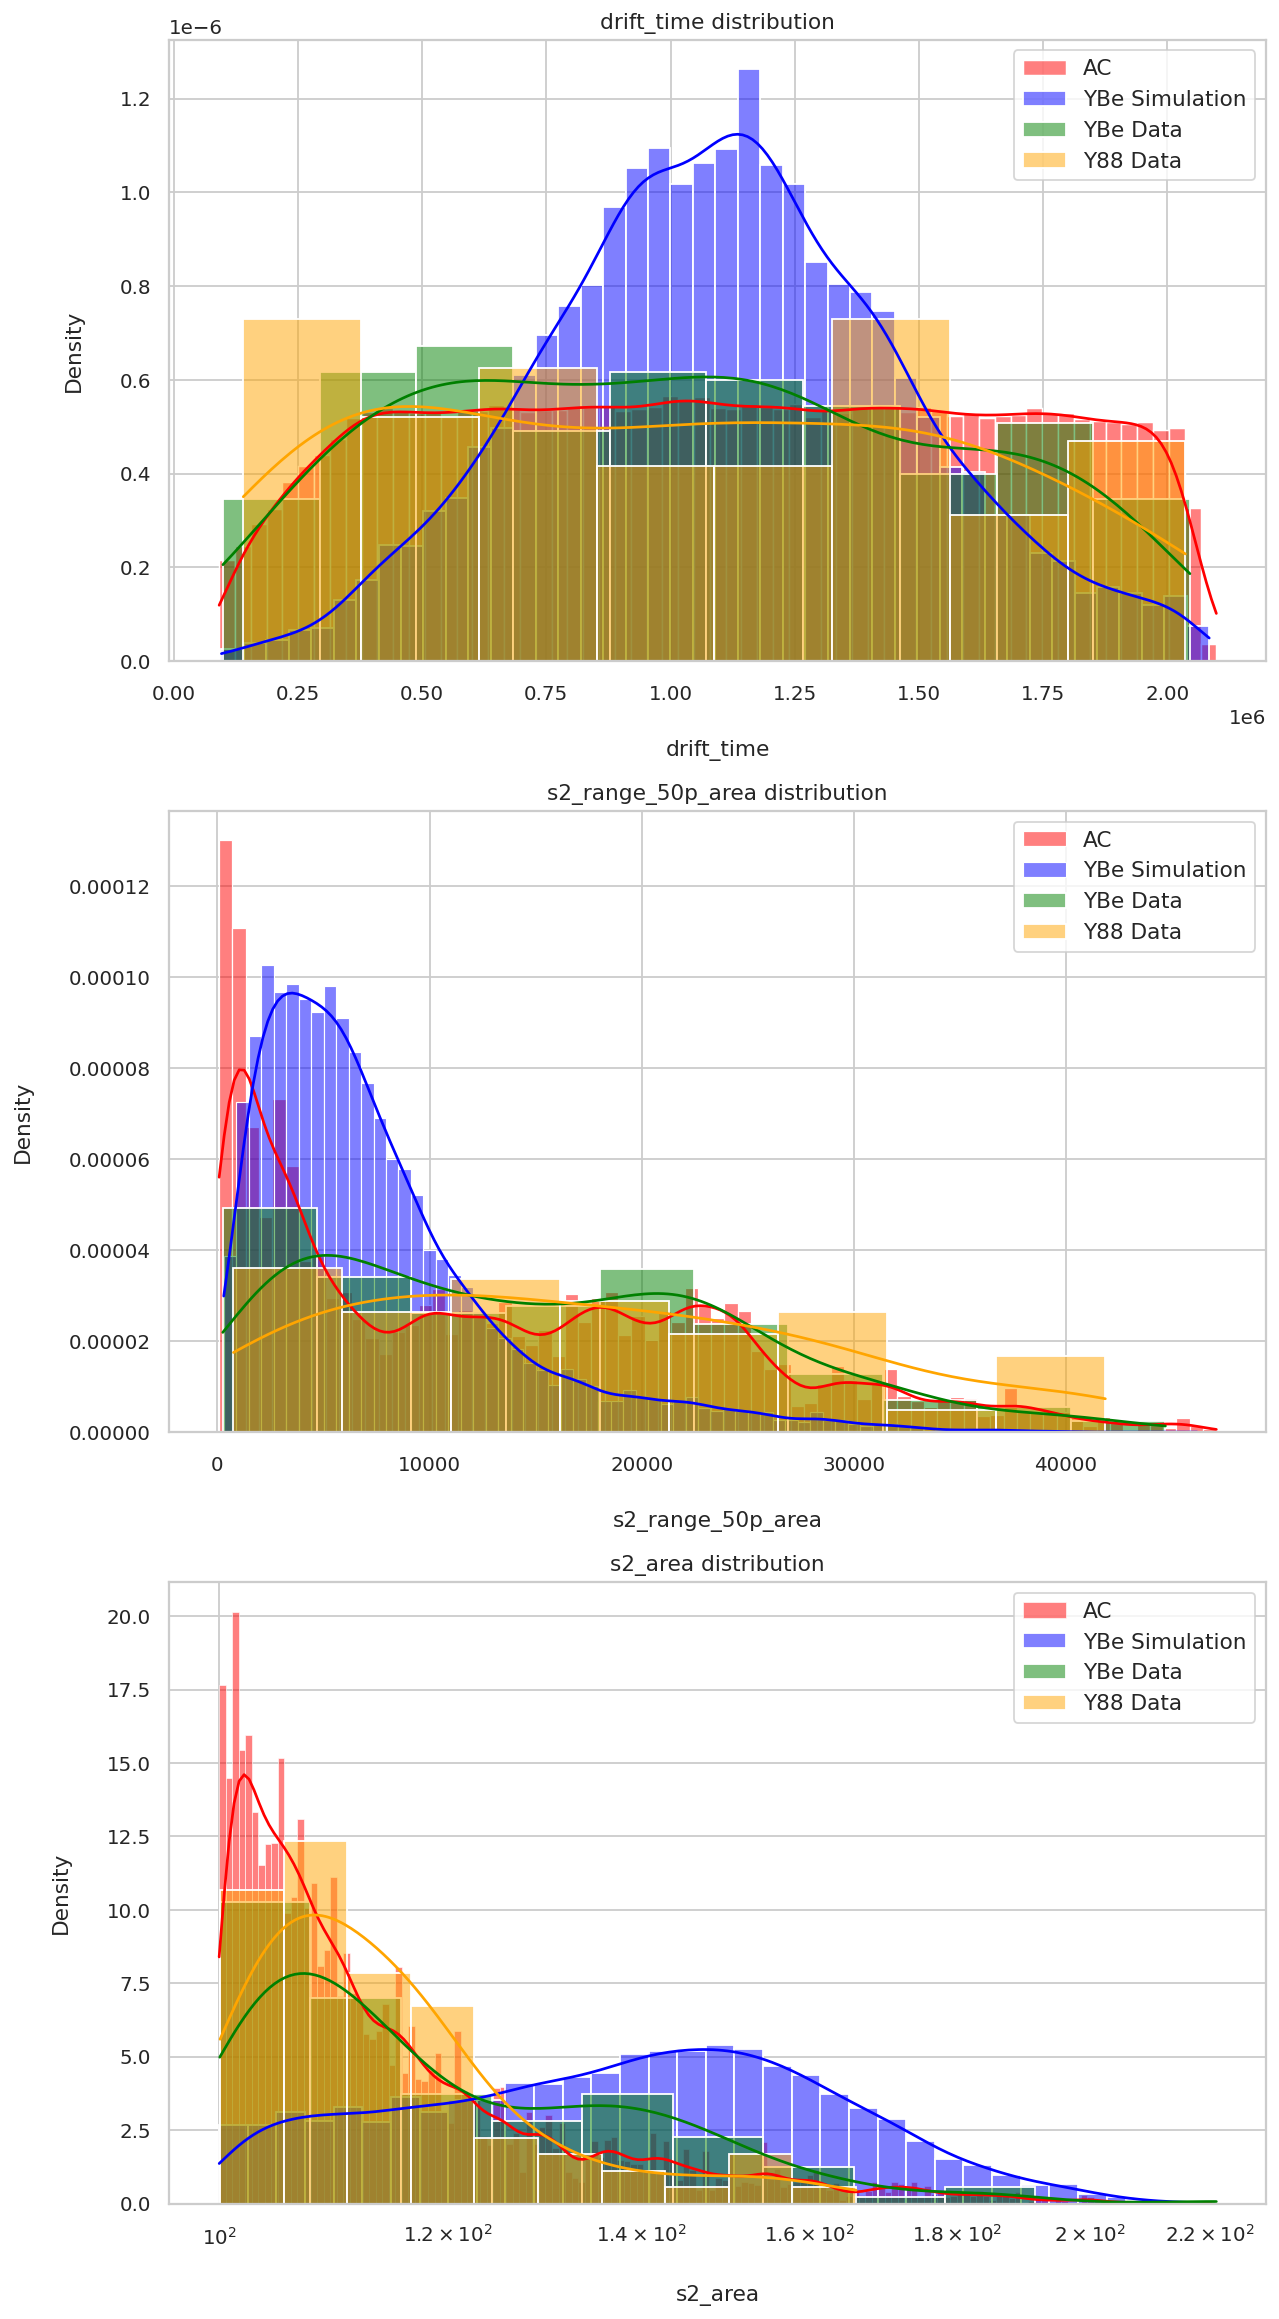

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Choose the common features for all dataframes
features = ['drift_time', 's2_range_50p_area', 's2_area']
names=['AC','YBe Simulation','YBe Data']

# Create a grid of subplots with three rows
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 18))

# Loop through the features and plot each one on its corresponding subplot
for i, feature in enumerate(features):
    log_scale = False
    if feature == 's2_area':
        log_scale = True
    sns.histplot(ac_sim_clean[feature], kde=True, label='AC', ax=axs[i], color='red', stat='density', log_scale=log_scale)
    sns.histplot(sim_clean[feature], kde=True, label='YBe Simulation', ax=axs[i], color='blue', stat='density', log_scale=log_scale)
    sns.histplot(data_clean[feature], kde=True, label='YBe Data', ax=axs[i], color='green', stat='density', log_scale=log_scale)
    sns.histplot(bkg_clean[feature], kde=True, label='Y88 Data', ax=axs[i], color='orange', stat='density', log_scale=log_scale)
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('Density')
    axs[i].set_title(f'{feature} distribution')
    axs[i].legend(fontsize=12)

plt.tight_layout()
plt.show()


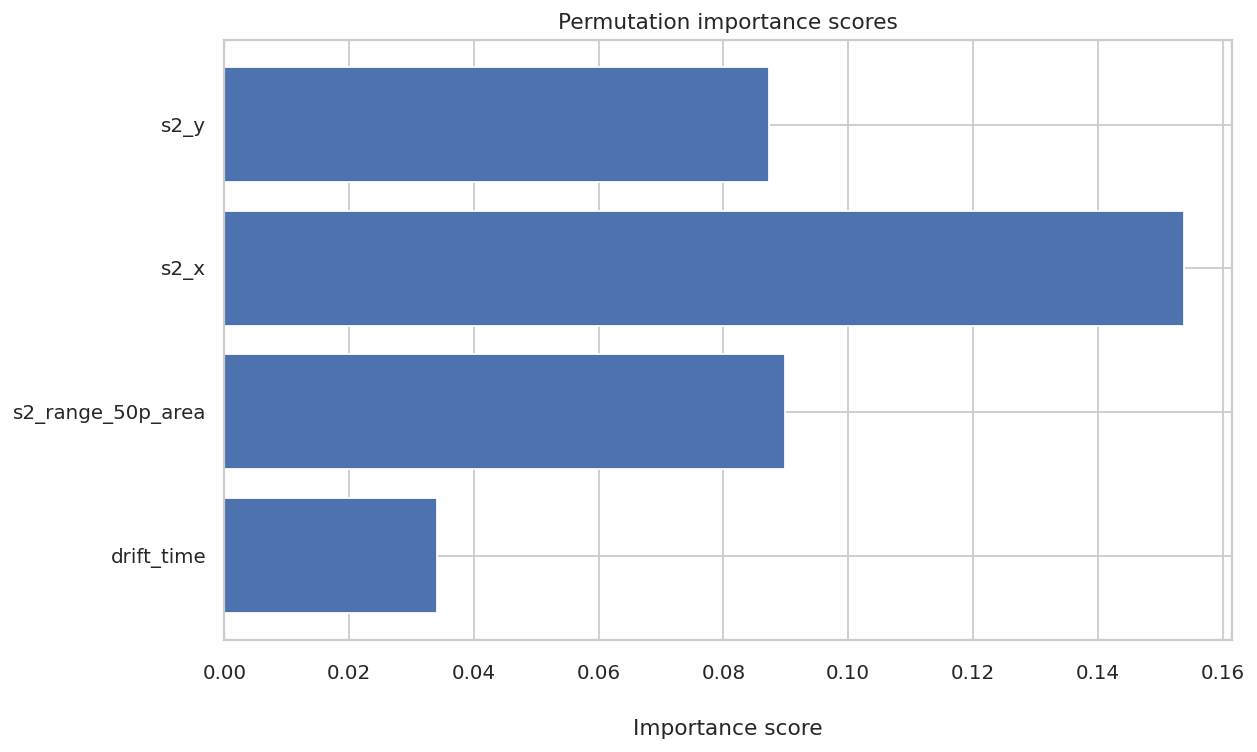

In [28]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt


# Calculate permutation importance scores
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=0)
importance_scores = result.importances_mean

# Visualize the results
fig, ax = plt.subplots()
ax.barh(range(len(importance_scores)), importance_scores)
ax.set_yticks(range(len(importance_scores)))
ax.set_yticklabels(X_test.columns)
ax.set_xlabel('Importance score')
ax.set_title('Permutation importance scores')
plt.show()


In [29]:
def other_s2_cuts(df):
    mask=df.cut_s2_single_scatter
    mask&=df.cut_s2_pattern
    mask&=df.cut_s2_width_wire_modeled_wimps
    return df[mask]

In [30]:
def ac_cut(df):
    return df[df['ac_score'] < ac_thred]

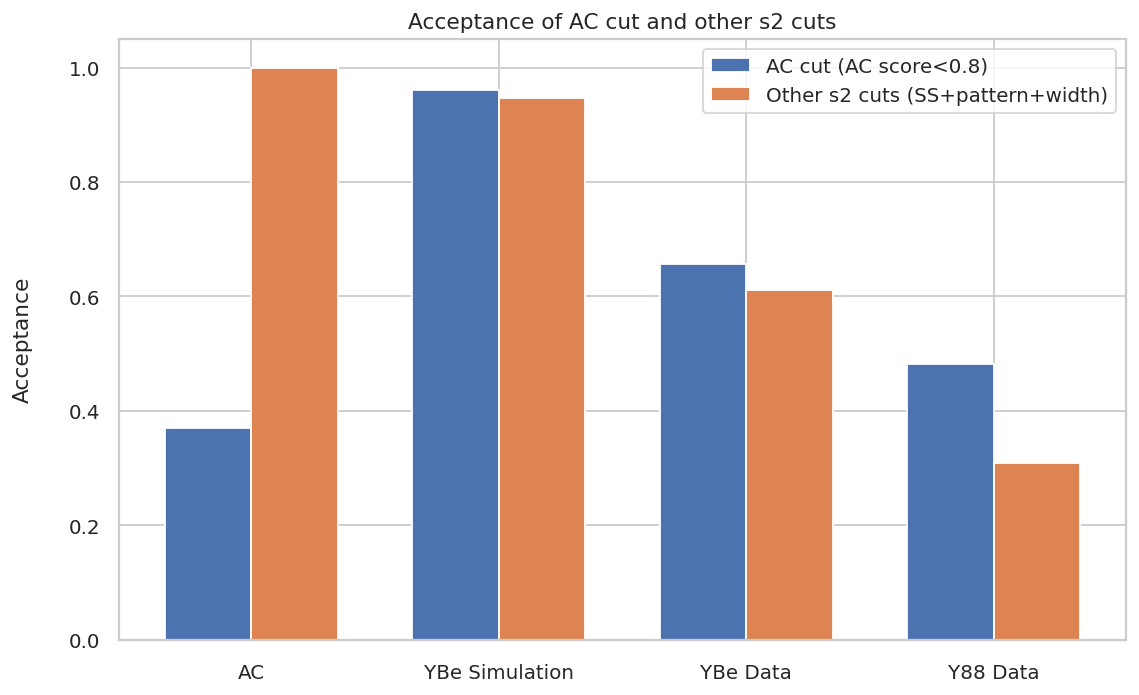

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define the acceptance functions
def ac_cut(df):
    return df[df['ac_score'] < ac_thred]

def other_s2_cuts(df):
    mask=df.cut_s2_single_scatter
    mask&=df.cut_s2_pattern
    mask&=df.cut_s2_width_wire_modeled_wimps
    return df[mask]

# Calculate the acceptance for each dataframe and cut
ac_acceptance = []
other_s2_acceptance = []

for df in [ac_test, sim_test, data_clean, bkg_clean]:
    ac_acceptance.append(len(ac_cut(df)) / len(df))
    other_s2_acceptance.append(len(other_s2_cuts(df)) / len(df))

# Create the bar plot
x = np.arange(4)
width = 0.35
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/2, ac_acceptance, width, label=f'AC cut (AC score<{ac_thred})')
ax.bar(x + width/2, other_s2_acceptance, width, label='Other s2 cuts (SS+pattern+width)')
ax.set_xticks(x)
ax.set_xticklabels(['AC','YBe Simulation','YBe Data','Y88 Data'])
ax.set_ylabel('Acceptance')
ax.set_title('Acceptance of AC cut and other s2 cuts')
ax.legend()
plt.show()


In [32]:
#s2 acc
def acc_cut(df):
    acc=[]
    size=25
    bins=np.arange(100,1000,size)
    for i in bins[:-1]:
        df_temp=df[(df.cs2>i)&(df.cs2<=i+size)]
        if(len(df_temp)==0):
            acc.append(np.nan)
        else:
            acc.append(len(ac_cut(df_temp))/len(df_temp))
    plt.plot(bins[:-1]+size/2,acc)
    plt.xlabel('S2 [PE]')
    return acc

In [34]:
sim_test['cut_ac']=sim_test['ac_score'] < ac_thred

100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


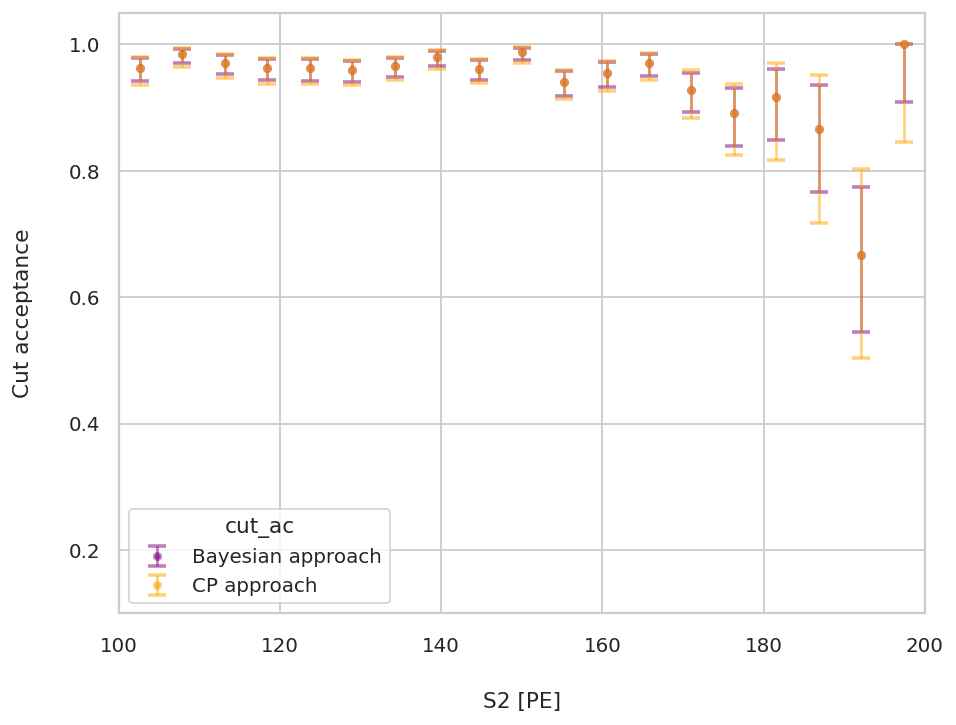

cut_ac: 0.939


In [35]:
from cutax.cut_efficiency import CutAcceptance
ca = CutAcceptance(sim_test, prior_cuts=[], cut_list=['cut_ac'])
s2_bins=np.linspace(100,200,20)
s2_cumu_acc_array, s2_full_acc_array = cututils.get_cumu_acc(
    ca, space='s2_area', 
    quality_cuts=['cut_ac'],
    bins=s2_bins, full_output=True)
for cut_name, acc_array in s2_full_acc_array.items():
    fig = ca.plot_cut_acceptance(acc_array, cut_name=cut_name, x_label='S2 [PE]')
    fig.set_size_inches(8, 6)
    plt.ylim(0.1, 1.05)
    plt.xlim(s2_bins[0], s2_bins[-1])
    plt.grid()
    plt.show()
    avg_acc = cututils.get_const_avg(acc_array)
    print(f'{cut_name}: {avg_acc:.3f}')

In [36]:
acc_array['acceptance']

array([0.96330275, 0.984375  , 0.97037037, 0.96240602, 0.96212121,
       0.95890411, 0.96621622, 0.98026316, 0.96103896, 0.98742138,
       0.94039735, 0.95535714, 0.97087379, 0.92857143, 0.89130435,
       0.91666667, 0.86666667, 0.66666667, 1.        ])

In [37]:
acc_array['bin_center']

array([102.63157895, 107.89473684, 113.15789474, 118.42105263,
       123.68421053, 128.94736842, 134.21052632, 139.47368421,
       144.73684211, 150.        , 155.26315789, 160.52631579,
       165.78947368, 171.05263158, 176.31578947, 181.57894737,
       186.84210526, 192.10526316, 197.36842105])

In [38]:
model.save_model("below200.json")

In [40]:
loaded_model = xgb.XGBClassifier()
loaded_model.load_model('below200.json')